In [40]:
pr = 225,400 #PREPROCESSING_RESOLUTION, --preprocessing_resolution
fr = 0.001  #FRACTION_OF_ROWS_TO_REMOVE, --fraction_of_rows_to_remove
fc = 0.13   #FRACTION_OF_COLS_TO_REMOVE, --fraction_of_cols_to_remove
vth = 150    #VALUE_THRESHOLD, --value_threshold
es = 3     #EROSION_SIZE, --erosion_size
ds = 7     #DILATION_SIZE, --dilation_size
mpx = 1000 #MINIMUM NUMBER OF PIXELS, --minimum_number_of_pixels
saturation_threshold = (0, 60)     # Weiß hat extrem wenig S
value_threshold      = (180, 255)  # Weiß ist sehr hell
Bilddateiendung = 'jpg' #Dateiendung der Bilder, ohne ".", Achtung: 'jpg' ist nicht 'JPG'
fv=0 #value_to_fill: Wert, mit dem die abgeschnittenen Ränder aufgefüllt werden sollen

Die angegebenen Werte sind Standardwerte, die Sie anpassen sollen.

## Setup und Zugriff zu den Bilddaten

In [41]:
import sys
import os
import subprocess

# ============================================================================
# Modul-Check: Prüfe ob alle benötigten Module installiert sind
# ============================================================================
def check_required_modules(install_missing=False):
    """Prüft ob alle benötigten Module installiert sind
    
    Args:
        install_missing: Wenn True, werden fehlende Module automatisch installiert
    """
    # Debug-Informationen
    print("Python-Environment-Informationen:")
    print(f"  Python-Executable: {sys.executable}")
    print(f"  Python-Version: {sys.version}")
    print(f"  Python-Pfad: {sys.path[:2]}")
    print()
    
    required_modules = {
        'numpy': 'numpy',
        'matplotlib': 'matplotlib',
        'skimage': 'scikit-image',
        'sklearn': 'scikit-learn',
        'scipy': 'scipy',
        'progressbar': 'progressbar2',  # Paket heißt progressbar2, Modul heißt progressbar
        'PIL': 'Pillow',
        'pandas': 'pandas'
    }
    
    missing_modules = []
    for module_name, package_name in required_modules.items():
        try:
            __import__(module_name)
            print(f"✓ {package_name} ist installiert")
        except ImportError as e:
            missing_modules.append(package_name)
            print(f"✗ {package_name} fehlt! (Import-Fehler: {e})")
    
    if missing_modules:
        print("\n" + "="*60)
        print("FEHLER: Folgende Module fehlen:")
        for mod in missing_modules:
            print(f"  - {mod}")
        
        if install_missing:
            print("\nVersuche fehlende Module automatisch zu installieren...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing_modules)
                print("✓ Installation erfolgreich! Bitte führen Sie diese Zelle erneut aus.")
                return False  # False zurückgeben, damit der Benutzer die Zelle nochmal ausführt
            except Exception as e:
                print(f"✗ Automatische Installation fehlgeschlagen: {e}")
        
        print("\nBitte installieren Sie die fehlenden Module mit:")
        print(f"  python -m pip install {' '.join(missing_modules)}")
        print("\nOder installieren Sie alle Module aus requirements.txt:")
        print("  python -m pip install -r requirements.txt")
        print("\nHinweis: Falls Sie Jupyter verwenden, stellen Sie sicher,")
        print("dass der Kernel das richtige Python-Environment verwendet!")
        print("="*60)
        raise ImportError(f"Fehlende Module: {', '.join(missing_modules)}")
    
    print("\n✓ Alle benötigten Module sind installiert!\n")
    return True

# Prüfe Module vor dem Import (mit automatischer Installation)
try:
    check_required_modules(install_missing=True)
except ImportError:
    # Falls automatische Installation fehlgeschlagen ist, versuche es nochmal ohne Installation
    print("\nBitte installieren Sie die fehlenden Module manuell und führen Sie diese Zelle erneut aus.")
    raise

# Füge das scripts-Verzeichnis zum Python-Pfad hinzu
scripts_path = os.path.join(os.getcwd(), 'scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# Jetzt können wir sicher importieren
from object_extraction import *

Python-Environment-Informationen:
  Python-Executable: d:\dev\anaconda\python.exe
  Python-Version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
  Python-Pfad: ['d:\\dev\\anaconda\\python312.zip', 'd:\\dev\\anaconda\\DLLs']

✓ numpy ist installiert
✓ matplotlib ist installiert
✓ scikit-image ist installiert
✓ scikit-learn ist installiert
✓ scipy ist installiert
✓ progressbar2 ist installiert
✓ Pillow ist installiert
✓ pandas ist installiert

✓ Alle benötigten Module sind installiert!



In [42]:
# ============================================================================
# Import-Block: Alle benötigten Bibliotheken
# ============================================================================

# Standard-Bibliotheken
import os
import sys
from pathlib import Path

# Numerische und wissenschaftliche Bibliotheken
import numpy as np
import pandas as pd

# Bildverarbeitung
from PIL import Image
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import erosion, closing, area_closing, opening, dilation, square
from skimage.transform import resize
from skimage.io import imsave

# Visualisierung
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
from matplotlib.pyplot import imshow

# Hilfsfunktion für Bildanzeige
def show_image(im):
    """Zeigt ein Bild an (PIL Image oder NumPy Array)"""
    imshow(im)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

# ============================================================================
# Setup: Füge scripts-Verzeichnis zum Python-Pfad hinzu
# ============================================================================
scripts_path = os.path.join(os.getcwd(), 'scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# ============================================================================
# Import der Verarbeitungsschritte aus den Skripten
# ============================================================================
# WICHTIG: Module neu laden, um sicherzustellen, dass die neueste Version verwendet wird
import importlib

# Lade Module neu, falls sie bereits importiert wurden
modules_to_reload = [
    'scripts.schritt0_bild_laden',
    'scripts.schritt1_aufloesungsreduktion',
    'scripts.schritt2_raender_abschneiden',
    'scripts.schritt3_hintergrundschwellwert',
    'scripts.schritt4_morphologische_transformation',
    'scripts.schritt5_objekte_extrahieren',
    'scripts.schritt6_kleine_objekte_filtern',
    'object_extraction',
    # Auch ohne scripts-Präfix prüfen
    'schritt0_bild_laden',
    'schritt1_aufloesungsreduktion',
    'schritt2_raender_abschneiden',
    'schritt3_hintergrundschwellwert',
    'schritt4_morphologische_transformation',
    'schritt5_objekte_extrahieren',
    'schritt6_kleine_objekte_filtern'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        try:
            importlib.reload(sys.modules[module_name])
        except Exception:
            pass  # Ignoriere Fehler beim Reload

from scripts.schritt0_bild_laden import choose_an_image
from scripts.schritt1_aufloesungsreduktion import resize_image
from scripts.schritt2_raender_abschneiden import fill_borders
from scripts.schritt3_hintergrundschwellwert import create_mask_from_image
from scripts.schritt4_morphologische_transformation import apply_morphology
from scripts.schritt5_objekte_extrahieren import extract_objects
from scripts.schritt6_kleine_objekte_filtern import filter_small_objects, print_region_sizes

# Import aus object_extraction.py (für zusätzliche Funktionen)
from object_extraction import *

print("✓ Alle Bibliotheken und Verarbeitungsschritte wurden importiert!")


✓ Alle Bibliotheken und Verarbeitungsschritte wurden importiert!


In [43]:
!ls /data/

Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Wenn das geklappt hat, haben Sie Zugriff auf die Daten! In der nächsten Zelle muss einfach der Pfad richtig angepasst werden. Dann sind Sie gerüstet für den Rest des Notebooks. Kopieren Sie jenen Pfad als String in die folgende Variable:

Als nächstes benötigen wir den Pfad zu `lcl_colab/1_object_extraction`. Er muss in sys.path zu finden sein. In der nächsten Zelle wird dies getestet:

Nun sollte die Datei `object_extraction.py` gefunden werden und das Modul object_extraction importiert werden können

Laden wir ein Bild!

Inhalt von data:
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\schraubenschluessel
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\schraubenzieher
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\seidenschneider
Gewählte Klasse: schraubenzieher
Datei: IMG_1802.JPEG


<Axes: >

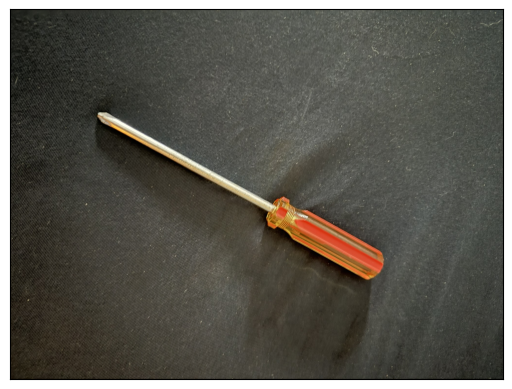

In [44]:
# Pfade relativ zum Workspace-Verzeichnis
base_path = Path(os.getcwd()) / "data"
dataset_paths = {
    "schraubenschluessel": base_path / "schraubenschluessel",
    "schraubenzieher": base_path / "schraubenzieher",  # Achtung: Tippfehler im Verzeichnisnamen
    "seidenschneider": base_path / "seidenschneider"
}

print("Inhalt von data:")
if base_path.exists():
    for p in base_path.iterdir():
        print("-", p)
else:
    print(f"Warnung: Verzeichnis {base_path} existiert nicht!")

# Lade ein Bild mit der importierten Funktion (aus Zelle 5)
im, klasse = choose_an_image(dataset_paths)
show_image(im)


# Adaption der Parameter
Wir haben Zugriff auf die Bilddaten, nun möchten wir die Parameterwerte auswählen, welche die Objekte gut vom Hintergrund isolieren. Die Funktion `process_file` erledigt das.

Das Vorgehen dabei ist Folgendes:
1. Lade das Bild und reduziere die Auflösung: Parameter **`pr`** enthält ein Tupel mit der Anzahl Pixelzeilen und der Anzahl Pixelspalten. Dies dient hauptsächlich der Beschleunigung der weiteren Verarbeitung.
2. Schneide jeweils an den Rändern einen Prozentsatz der Zeilen bzw. Spalten ab: Der Prozentsatz der Zeilen ist durch **`fr`**, jener der Spalten durch **`fc`** gegeben.
3. Es wird ein Schwellwert auf den value-Wert (in der hsv-Farbdarstellung) angewendet, um den dunklen (`sign`=+1) oder hellen (`sign`=-1) Hintergrund zu erkennen. Dies ergibt eine Maske (binärer Array), welcher Vordergrundpixel identifiziert.
4. Es werden kleine Artefakte auf der Maske durch Erosion und Dilatation entfernt. Die Parameter `es` und `ds` geben die Grössen der Erosions- und Dilatationsmasken an.
5. Die Objekte werden ausgeschnitten, d.h. separate Objekte werden identifiziert, und um jedes Objekt wird eine enge rechteckige *Bounding Box* gesetzt.
6. Sollte der Ausschnitt weniger als **`mpx`** Pixel enthalten, wird er verworfen. Dies ist nötig, weil manchmal Reflexionen o.ä. zusätzliche kleine Ausschnitte erzeugen, welche aber nicht ein Objekt enthalten.
7. Ein neues Bild wird abgespeichert, welches nur noch das (ausgeschnittene) Bildelement enthält.


Wenn dies gelingt, sind die Bilder in einer geeigneten Form für Deep Learning.

Im Folgenden wird dieser Vorgang für ein (von Ihnen gewähltes) Bild durchgeführt. Passen Sie die Parameter so an, dass die Extraktion gut gelingt.  
Die Parameter sollten Sie hier anpassen:


### Schritt 0: Laden des Bildes

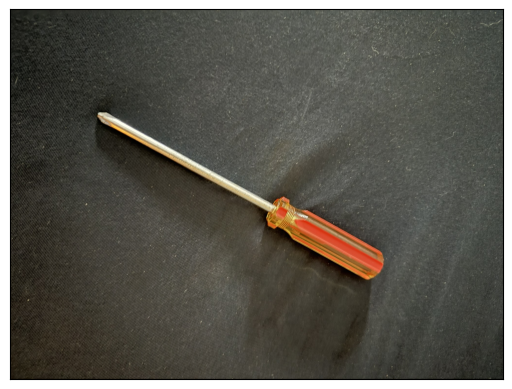

In [45]:
show_image(im);

Das Bild hat aktuell die Auflösung

In [46]:
np_im = np.array(im)
print("Shape:", np_im.shape)
print("Size:", im.size)
print("Mode:", im.mode)

Shape: (1536, 2048, 3)
Size: (2048, 1536)
Mode: RGB


### Schritt 1: Auflösungsreduktion

Die Bilder können zu hoch aufgelöst sein für unsere Anwendung, wodurch sich die Rechenzeit der folgenden Operationen vervielfacht. Die Vorverarbeitungsroutine `object_extraction.py` beginnt daher damit, mit der `--preprocessing_resolution` (oder `-pr`) das Bild zu verkleinern:

Ursprüngliche Bildgröße: 2048 x 1536
Neue Bildgröße (proportional): 300 x 225
Skalierungsfaktor: 0.146


<Axes: >

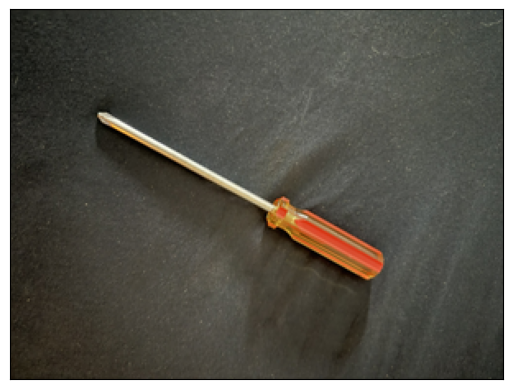

In [47]:
# Importiere die Funktion aus dem Skript
from scripts.schritt1_aufloesungsreduktion import resize_image

# Verwende die Funktion
im_resized = resize_image(im, pr)
show_image(im_resized)

Die Auflösung sollte nun Ihren Wünschen entsprechen (`NrRows`, `NrCols`, Anzahl Farbkanäle):

In [48]:
np_im = np.array(im_resized)
print("Shape:", np_im.shape)
print("Size:", im_resized.size)
print("Mode:", im_resized.mode)

Shape: (225, 300, 3)
Size: (300, 225)
Mode: RGB


## Schritt 2: Ränder abschneiden
Als nächstes müssen ev. die Ränder des Bildes überdeckt werden. Damit können Artefakte beseitigt werden, z.B. wenn der schwarze Hintergrund nicht bis an den Rand des Bildes reicht. `fraction_of_rows_to_remove` und `fraction_of_cols_to_remove` geben an, wieviel abgeschnitten wird. Aufgefüllt werden die Pixel mit dem Wert `value_to_fill=0` (in allen Farbkanälen).

In [49]:
# Importiere die Funktion aus dem Skript
from scripts.schritt2_raender_abschneiden import fill_borders

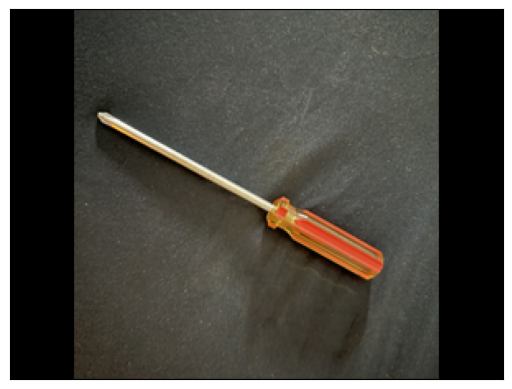

In [50]:
im_filled = fill_borders(im_resized,value_to_fill=fv,fraction_of_rows_to_remove=fr,
                         fraction_of_cols_to_remove=fc)
show_image(im_filled);

**Aufgabe 1:** Finden Sie für Ihre Bilder passende Werte für `fraction_of_rows_to_remove` und `fraction_of_cols_to_remove`.

### Schritt 3: Hintergrundschwellwert bestimmen
Wählen Sie zunächst sign=+1 für Schwarzen Hintergrund oder sign=-1 für weissen Hintergrund.

Als nächstes soll ein Schwellwert im Farbraum das Objekt vom Hintergrund isolieren. Wir arbeiten im *hsv*-Raum: hue, saturation und value sind die drei Farbdimensionen, für welche jeweils ein Mindestwert (für sign=+1) bzw. Maximalwert (für sign=-1) für Vordergrundpixel festgelegt werden kann. Berechnet wird konkret: `mask = sign*im_hsv[:,:,2]<value_schwellwert*sign` (etc.).

im_filled Shape: (225, 300, 3), dtype: uint8


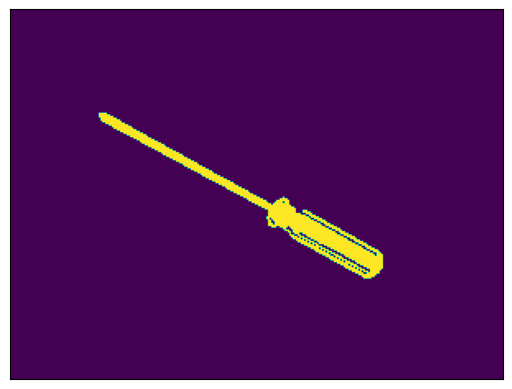

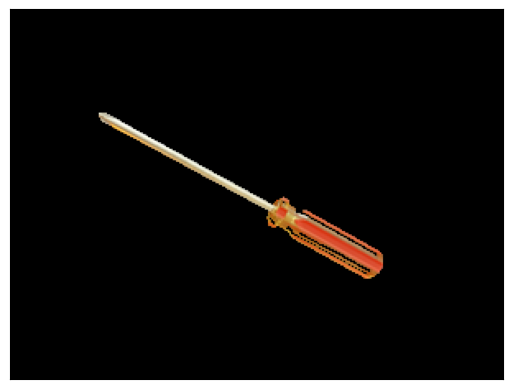

In [51]:
# Verwende die importierte Funktion aus dem Skript (aus Zelle 5)
mask, masked_image = create_mask_from_image(
    im_filled,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)

plt.figure();show_image(mask);
plt.figure();show_image(masked_image);

**Aufgabe 2:** Finden Sie Werte für `hue_schwellwert`, `saturation_schwellwert` und `value_schwellwert` so, dass die Maske möglichst gut zum Objektumriss passt. Bei der Wahl der Schwellwerte muss man aufpassen, dass sie nicht nur auf diesem einen Bild passen, sondern auch auf allen anderen!

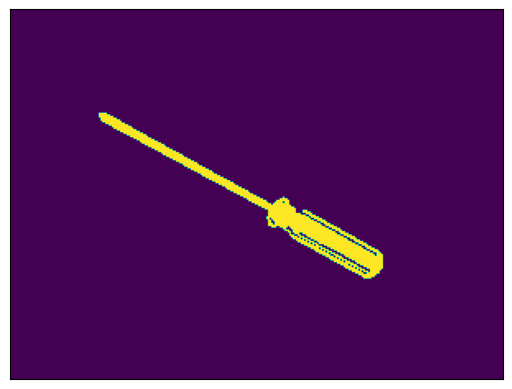

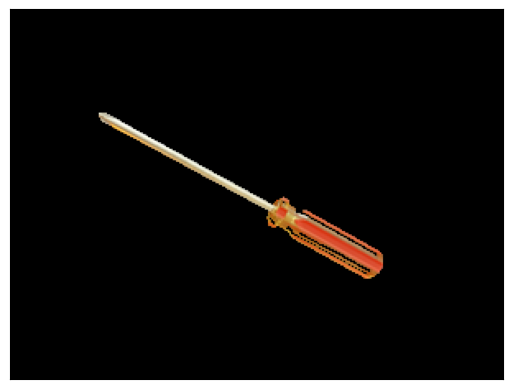

In [52]:
mask = generate_mask_with_hsv_threshold(
    np.array(im_filled),
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=150   # oder 160–180
)

# Zeige die Maske und das maskierte Bild an
plt.figure();show_image(mask);
masked_image = create_masked_image(im_filled, mask)
plt.figure();show_image(masked_image);

## Schritt 4: Erosion und Dilatationsfilgergrössen bestimmen

In [53]:
morphology_transform??

Signature:
morphology_transform(
    mask,
    shape=<function square at 0x000000000F4D6520>,
    erosion_size=5,
    dilation_size=50,
)
Source:   
def morphology_transform(mask,shape = square,erosion_size=5,dilation_size=50):
    """
    Important morphological preprocessing TUNE HERE IF NECESSARY
    """
    mask = erosion(mask.copy(),shape(erosion_size))        
    mask = dilation(mask,shape(dilation_size))
    return mask
File:      d:\dev\git\privat\studium\dsci-semesterarebeit\scripts\object_extraction.py
Type:      function

Wenn Hintergrundregionen übrigbleiben, dann ergibt dies zusätzliche Trainingsbilder, welche nicht einer Klasse zugeordnet sind- und es kostet auch viel Rechenzeit. Kleine, isolierte Maskenpixel möchten wir daher als nächstes durch Erosion entfernen.

**Aufgabe 3:** Finden Sie Werte für es und ds, welche möglichst keine vereinzelte Hintergrundpixel in der Maske übrig lassen:

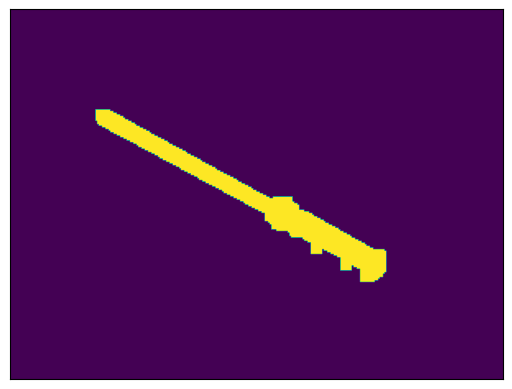

In [54]:
# Verwende die importierte Funktion aus dem Skript (aus Zelle 5)
morphed_mask = apply_morphology(mask, erosion_size=es, dilation_size=ds)
show_image(morphed_mask);

Ev. haben Sie auch Glück, und Sie sehen oben nur eine einzige zusammenhängende gelbe Struktur? Dann können Sie die Werte so lassen, wie sie sind!

`create_mask` ist nun einfach eine Routine, welche die obigen Schritte der Maskenbildung zusammenfasst. Sie sollte das gleiche Bild `morphed_mask` wie oben erstellen:

In [55]:
create_mask??

Signature:
create_mask(
    im,
    fraction_of_rows_to_remove=0.0,
    fraction_of_cols_to_remove=0.1,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=100,
    erosion_size=5,
    dilation_size=50,
    value_to_fill=0,
)
Source:   
def create_mask(im,fraction_of_rows_to_remove=0.0,fraction_of_cols_to_remove=0.1,hue_threshold=None,saturation_threshold=None,value_threshold=100,erosion_size=5,dilation_size=50,value_to_fill=0):
    """
    Erstelle eine (binÃ¤re) Maske aus dem Bild im durch Randbeschneidung, HSV-Schwellwertbildung und morphologischen Transformationen. 
    Die Maske soll die  relevanten Ausschnitte von im angeben.

    """
    #Schneide die RÃ¤nder des Bildes ab, wo sicher keine Objekte drin sind
    im_filled= fill_borders(im,value_to_fill=value_to_fill,fraction_of_rows_to_remove=fraction_of_rows_to_remove,fraction_of_cols_to_remove=fraction_of_cols_to_remove)

    #Generiere eine Maske (binÃ¤res Bild), welche Vordergrundpixel mit True bezeichn

<Axes: >

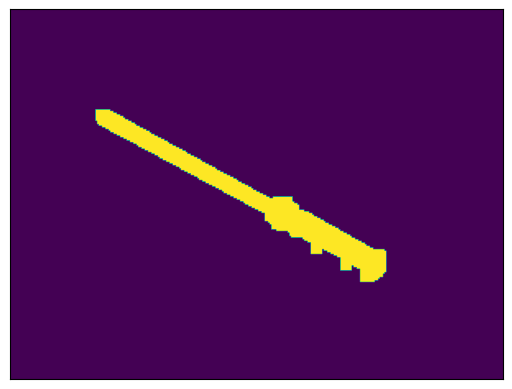

In [56]:
morphed_mask, im_filled = create_mask(
    np.array(im_resized), 
    fraction_of_rows_to_remove=fr,
    fraction_of_cols_to_remove=fc,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=3,
    dilation_size=7
)

show_image(morphed_mask)

Nun wird die Maske benutzt, um das Objekt (oder die Objekte) aus dem Bild auszuschneiden:

(225, 300, 3)

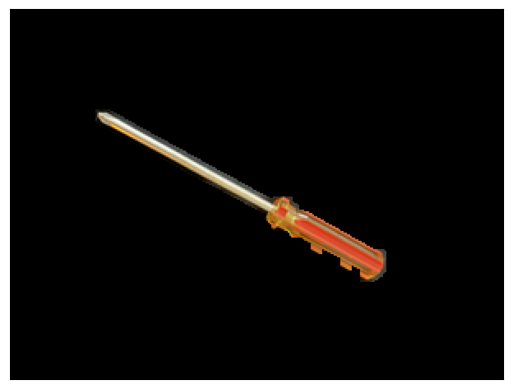

In [57]:
masked_image = create_masked_image(im_filled,morphed_mask)
show_image(masked_image);
masked_image.shape

Hier sollte ein Bild zu sehen sein, welches einen komplett schwarzen Hintergrund hat, und nur die relevanten Objekte zeigt. Als nächstes hätten wir gerne von jedem Objekt ein separates Bild, so dass wir darauf unseren Bildklassifikator trainieren können.

## Schritt 5: Objekte ausschneiden
Wir haben den Hintergrund eliminiert. Damit ist es nun leichter, die Objekte voneinander zu trennen. Eine Funktion von [scikit-image](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) tut dies:

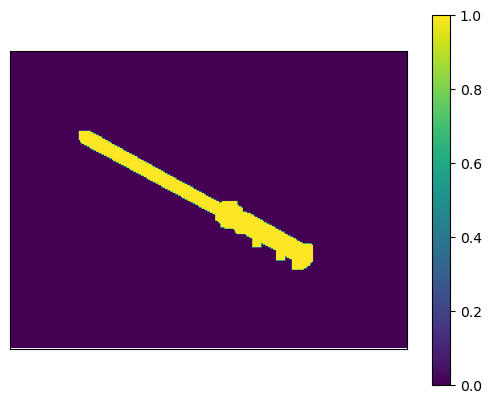

In [58]:
from skimage.measure import label
label_img = label(morphed_mask)
show_image(label_img)
plt.colorbar();

Falls das obige Bild wie eine Maske aussieht: Vermutlich liegt nur ein Bild vor- deren Pixel wird dann mit dem Wert "1" aufgefüllt. Wäre ein zweites Objekt vorhanden, würde dieses mit dem Wert "2" aufgefüllt und wäre in einer leicht anderen Farbe sichtbar. Aus diesem gelabelten Bild werden nun Teilbilder extrahiert, welche jeweils nur ein Objekt enthalten:

In [59]:
label_img.shape,masked_image.shape

((225, 300), (225, 300, 3))

In [60]:
regionlist,regions = extract_regions(label_img,masked_image,fraction_of_rows_to_remove=fr)
len(regionlist)

1

Alle obigen Schritte sind in der Funktion image_preprocessing zusammengefasst:

In [61]:
image_preprocessing?

Signature: image_preprocessing(im, **kwargs)
Docstring:
Diese Routine enthÃ¤lt die ganze Vorverarbeitung eines Rohbildes. RÃ¼ckgabe:
regionlist und regions: enthalten Informationen Ã¼ber die gefundenen Objekte
mask: Maske, mit welcher die Objekte ausgeschnitten wurden
masked_image: Originalbild mit unterdrÃ¼cktem Hintergrund
File:      d:\dev\git\privat\studium\dsci-semesterarebeit\scripts\object_extraction.py
Type:      function

In [62]:
regionlist,regions,mask,masked_image = image_preprocessing(
    np.array(im_resized),   # <-- HIER wichtig!
    fraction_of_rows_to_remove=fr,
    fraction_of_cols_to_remove=fc,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds,
    value_to_fill=fv
)

print(f"Anzahl gefundene Bereiche: {len(regionlist)}")


Anzahl gefundene Bereiche: 1


In [63]:
label_img.shape,masked_image.shape,len(regions)

((225, 300), (225, 300, 3), 1)

<Axes: >

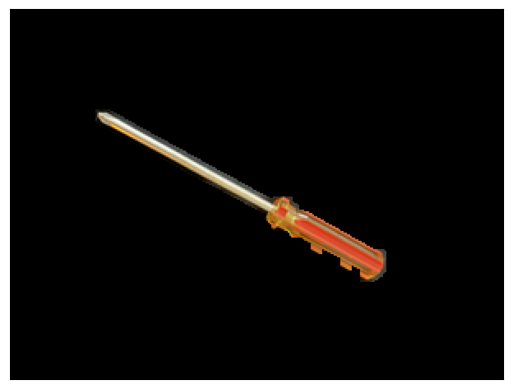

In [64]:
show_image(masked_image)

## Schritt 6: Kleine Objekte (Artefakte) ignorieren
Manchmal sind einige der gefundenen Regionen viel zu klein, um echte Objekte zu sein. Es gibt eine Option `--minimum-number-of-pixels` bzw. `-mpx`, welche Regionen unterdrückt, welche zu klein sind. Die Grösse der Regionen wird hier ausgegeben, um diesen Parameter gut einstellen zu können.

Region 0:   2705


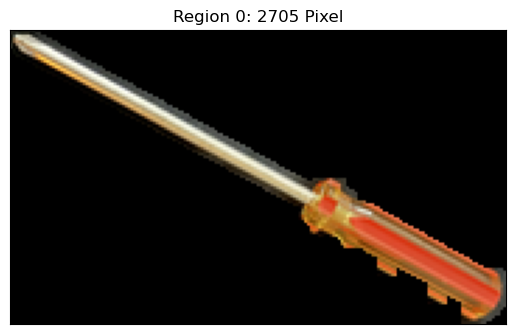

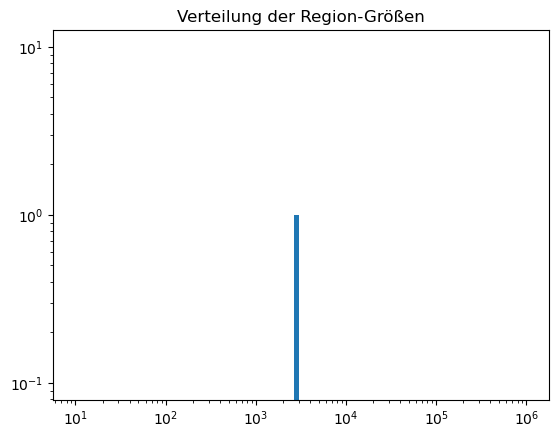

In [65]:
if len(regions)<10:
    for ireg,reg in enumerate(regions):
        print(f"Region {ireg}: {int(reg.area):>6}")
        # Zeige jede Region als Bild (wie im Original)
        plt.figure()
        plt.imshow(reg.image_intensity)
        plt.xticks([]); plt.yticks([])  # Wir brauchen keine x- und y-Achse
        plt.title(f"Region {ireg}: {int(reg.area)} Pixel")
    # Zeige auch bei wenigen Regionen ein Histogramm
    plt.figure()
    plt.hist([reg.area for reg in regions],bins=np.logspace(1,6,100))
    plt.gca().set_xscale('log') #ev. sieht man damit etwas mehr
    plt.gca().set_yscale('log')
    plt.title("Verteilung der Region-Größen")
    plt.show()
else:
    #for ireg,reg in enumerate(regions):
    #    print(f"{int(reg.area):<3} ",end='')

    plt.hist([reg.area for reg in regions],bins=np.logspace(1,6,100))
    plt.gca().set_xscale('log') #ev. sieht man damit etwas mehr
    plt.gca().set_yscale('log')
    plt.show()  # Zeige das Histogramm an

Schauen wir uns die extrahierten Regionen an - es sollten nicht zu viele sein.

**Aufgabe 4:** Bestimmen Sie einen geeigneten Wert von `mpx`, so dass nur relevante Regionen übrig bleiben. Tragen Sie den Wert in die Parameterliste ein.

Der `mpx`-Wert wird in der nächsten Zelle verwendet:

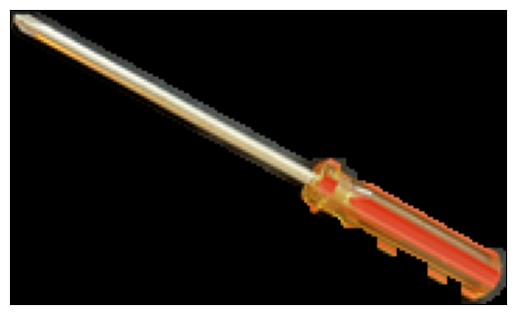

In [66]:
# Verwende mpx wie im Original (nicht 110000)
relevante_regionen =  [reg for reg in regions if reg.area >= mpx]

if len(relevante_regionen) == 0:
    print(f"Keine Regionen mit >= {mpx} Pixeln gefunden. Zeige alle Regionen:")
    relevante_regionen = regions  # Zeige alle Regionen, wenn keine gefilterten gefunden wurden

if len(relevante_regionen)<20:
    for reg in relevante_regionen:
        plt.figure()
        plt.imshow(reg.image_intensity)
        plt.xticks([]);plt.yticks([]) # Wir brauchen keine x- und y-Achse
    plt.show()  # Zeige alle Bilder an
else:
    print(f"Das würde {len(relevante_regionen)} Graphiken erzeugen! Ich mache lieber nichts...")

Sehen Sie hier Ihre extrahierten Objekte, und keine (oder nur wenige) Artefakte?  
Ja?  
Wirklich?  
**Cool!**  
Dann können wir nun versuchen, alle weiteren Daten zu verarbeiten. Das kann  in der Kommandozeile wie folgt erreicht werden:

In [67]:
Ausgabepfad = Path('/erstellt/object_extraction_output')
Ausgabepfad.mkdir(parents=True, exist_ok=True)
Ausgabepfad

WindowsPath('/erstellt/object_extraction_output')

In [68]:
from pathlib import Path

dataset_paths = {
    "schraubenzieher": Path("data/schraubenzieher"),
    "schraubenschluessel": Path("data/schraubenschluessel"),
    "seidenschneider": Path("data/seidenschneider"),
}

# Verwende einen lokalen Pfad statt des Kaggle-Pfads
output_path = Path("extracted")  # Relativer Pfad zum aktuellen Verzeichnis
output_path.mkdir(parents=True, exist_ok=True)
print(f"Extrahierte Bilder werden gespeichert in: {output_path.absolute()}")

for class_name, class_path in dataset_paths.items():
    print(f"\nExtrahiere Klasse: {class_name}")
    print("Pfad:", class_path)

    if not class_path.exists():
        print("  WARNUNG: Pfad existiert nicht – ueberspringe.")
        continue

    target_dir = output_path / class_name
    target_dir.mkdir(parents=True, exist_ok=True)

    # Suche nach verschiedenen Bildformaten (JPEG, jpg, jpeg, JPG, etc.)
    # Unterstützt sowohl Groß- als auch Kleinschreibung
    image_extensions = ["*.JPEG", "*.jpeg", "*.JPG", "*.jpg", "*.png", "*.PNG"]
    image_files = []
    for ext in image_extensions:
        image_files.extend(class_path.rglob(ext))
    
    # Entferne Duplikate (falls Dateien mit verschiedenen Groß-/Kleinschreibungen existieren)
    image_files = list(set(image_files))

    print(f"  {len(image_files)} Bilder gefunden")

    # Setze hue_threshold und saturation_threshold auf None, falls nicht definiert
    hue_thresh = hue_threshold if 'hue_threshold' in globals() else None
    sat_thresh = saturation_threshold if 'saturation_threshold' in globals() else None

    for file_path in image_files:
        process_file(
            file_path,
            fraction_of_rows_to_remove=fr,
            fraction_of_cols_to_remove=fc,
            hue_threshold=hue_thresh,
            saturation_threshold=None,
            value_threshold=vth,
            erosion_size=es,
            dilation_size=ds,
            min_num_pixels=mpx,
            preprocessing_resolution=pr,
            value_to_fill=fv,
            outputpath=str(target_dir),
        )

print("\nFertig! Extrahierte Bilder liegen unter:")
print(output_path)


Extrahierte Bilder werden gespeichert in: d:\dev\git\privat\Studium\dsci-semesterarebeit\extracted

Extrahiere Klasse: schraubenzieher
Pfad: data\schraubenzieher
  82 Bilder gefunden


INFO:object_extraction:Shapes of extracted regions: [(107, 50, 3)]
INFO:object_extraction:Shapes of extracted regions: [(124, 88, 3)]
INFO:object_extraction:Shapes of extracted regions: [(27, 197, 3)]
INFO:object_extraction:Shapes of extracted regions: [(167, 122, 3)]
INFO:object_extraction:Shapes of extracted regions: [(178, 27, 3)]
INFO:object_extraction:Shapes of extracted regions: [(29, 173, 3)]
INFO:object_extraction:Shapes of extracted regions: [(92, 97, 3), (8, 17, 3)]
INFO:object_extraction:skipping region: num_pix=121,shape:(8, 17, 3),area:121.0, as num_pix is < 1000
INFO:object_extraction:Shapes of extracted regions: [(120, 150, 3)]
INFO:object_extraction:Shapes of extracted regions: [(187, 39, 3)]
INFO:object_extraction:Shapes of extracted regions: [(72, 115, 3)]
INFO:object_extraction:Shapes of extracted regions: [(213, 65, 3)]
INFO:object_extraction:Shapes of extracted regions: [(68, 179, 3)]
INFO:object_extraction:Shapes of extracted regions: [(43, 259, 3)]
INFO:object_ex


Extrahiere Klasse: schraubenschluessel
Pfad: data\schraubenschluessel
  42 Bilder gefunden


INFO:object_extraction:Shapes of extracted regions: [(43, 272, 3)]
INFO:object_extraction:Shapes of extracted regions: [(205, 195, 3)]
INFO:object_extraction:Shapes of extracted regions: [(81, 213, 3)]
INFO:object_extraction:Shapes of extracted regions: [(127, 148, 3), (10, 9, 3)]
INFO:object_extraction:skipping region: num_pix=82,shape:(10, 9, 3),area:82.0, as num_pix is < 1000
INFO:object_extraction:Shapes of extracted regions: [(88, 210, 3), (13, 12, 3)]
INFO:object_extraction:skipping region: num_pix=127,shape:(13, 12, 3),area:127.0, as num_pix is < 1000
INFO:object_extraction:Shapes of extracted regions: [(11, 9, 3), (121, 133, 3)]
INFO:object_extraction:skipping region: num_pix=91,shape:(11, 9, 3),area:91.0, as num_pix is < 1000
INFO:object_extraction:Shapes of extracted regions: [(7, 7, 3), (197, 156, 3), (7, 7, 3)]
INFO:object_extraction:skipping region: num_pix=49,shape:(7, 7, 3),area:49.0, as num_pix is < 1000
INFO:object_extraction:skipping region: num_pix=49,shape:(7, 7, 3)


Extrahiere Klasse: seidenschneider
Pfad: data\seidenschneider
  38 Bilder gefunden


INFO:object_extraction:Shapes of extracted regions: [(147, 129, 3)]
INFO:object_extraction:Shapes of extracted regions: [(89, 155, 3)]
INFO:object_extraction:Shapes of extracted regions: [(111, 113, 3)]
INFO:object_extraction:Shapes of extracted regions: [(120, 71, 3)]
INFO:object_extraction:Shapes of extracted regions: [(60, 136, 3)]
INFO:object_extraction:Shapes of extracted regions: [(46, 135, 3)]
INFO:object_extraction:Shapes of extracted regions: [(86, 127, 3)]
INFO:object_extraction:Shapes of extracted regions: [(44, 149, 3)]
INFO:object_extraction:Shapes of extracted regions: [(83, 137, 3)]
INFO:object_extraction:Shapes of extracted regions: [(111, 144, 3)]
INFO:object_extraction:Shapes of extracted regions: [(164, 101, 3)]
INFO:object_extraction:Shapes of extracted regions: [(59, 141, 3)]
INFO:object_extraction:Shapes of extracted regions: [(55, 153, 3)]
INFO:object_extraction:Shapes of extracted regions: [(79, 142, 3)]
INFO:object_extraction:Shapes of extracted regions: [(73, 


Fertig! Extrahierte Bilder liegen unter:
extracted


#### Train-Test-Split
An dieser Stelle lohnt es sich, kurz innezuhalten: Unsere grandiose Strategie ist es, aus Bildern Objekte zu extrahieren und auf diesen dann ein Modell zu trainieren. Aber wir können nicht alle Daten als Trainingsdaten verwenden, sonst haben wir nichts mehr, um die *Generalisierungsfähigkeit* unseres Modells zu messen!  
Die Realität ist, dass wir nur ungern später nochmals neue Daten aufnehmen wollen. Die Liste in `df` oben ist alles, was uns zur Verfügung steht. Es macht daher Sinn, bereits jetzt einen Teil dieser Daten zurückzulegen und zu *schwören* diese Daten nicht für das Training zu benutzen. Wir brauchen ca. 20% *frische* Daten, an denen wir die Verallgemeinerungsfähigkeit unseres Modells überprüfen können.  
[Scikit-Learn](https://scikit-learn.org) bietet uns [hier](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) verschiedene Strategien an, wie wir aus unseren Trainingsdaten einen Testdatensatz absondern können. Wir könnten einfach [zufällig splitten](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit). Das ist naiv. Lieber eine [k-fache Kreuzvalidierung](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). Aber was, wenn zufälligerweise eine Klasse nur im Testdatensatz auftaucht, und gar nicht im Trainingsdatensatz?! Also [stratifizieren](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) wir. Ok- und was ist, wenn wir überprüfen wollen, dass wir in Bezug auf eine bestimmte Untergruppierung (z.B. nach Geschlecht, Ethnie,...) gut von einer Gruppe auf eine andere verallgemeinern können müssen? Dann darf eine [Gruppe nur in einem Fold vorkommen](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold). Sie sehen- richtig zu splitten kann herausfordernd sein!  
Hier jedenfalls möchten wir zumindest stratifizieren. Wir nehmen mal [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), um unsere Daten zu splitten.

In [69]:
import pandas as pd
from pathlib import Path

# Verwende den gleichen output_path wie in Cell 61
# Falls Cell 61 nicht ausgeführt wurde, verwende einen lokalen Pfad
try:
    # Versuche den output_path aus Cell 61 zu verwenden
    base = output_path
except NameError:
    # Falls output_path nicht definiert ist, verwende einen lokalen Pfad
    base = Path("extracted")  # Relativer Pfad zum aktuellen Verzeichnis
    if not base.exists():
        # Versuche auch einen absoluten Pfad
        base = Path(os.getcwd()) / "extracted"

print(f"Suche extrahierte Bilder in: {base}")

if not base.exists():
    print(f"WARNUNG: Der Pfad {base} existiert nicht!")
    print("Bitte führen Sie zuerst Cell 61 aus, um die Bilder zu extrahieren.")
    print("Oder passen Sie den Pfad manuell an.")
    df = pd.DataFrame(columns=["Dateiname", "Basisname", "Klassenlabel"])
else:
    rows = []
    
    for klasse in ["schraubenzieher", "schraubenschluessel", "seidenschneider"]:
        kpfad = base / klasse
        if kpfad.exists():
            for fn in kpfad.glob("*.*"):
                # Überspringe Verzeichnisse
                if fn.is_file():
                    rows.append({
                        "Dateiname": str(fn),           # voller Pfad
                        "Basisname": fn.name,           # z.B. "img_001.jpg"
                        "Klassenlabel": klasse          # z.B. "schraubenzieher"
                    })
        else:
            print(f"WARNUNG: Pfad {kpfad} existiert nicht für Klasse {klasse}")
    
    df = pd.DataFrame(rows)
    print(f"Gefunden: {len(df)} Dateien")
    if len(df) > 0:
        print(df.head())
        print(f"\nAnzahl Zeilen: {len(df)}")
    else:
        print("Keine Dateien gefunden! Bitte führen Sie zuerst Cell 61 aus.")

Suche extrahierte Bilder in: extracted
Gefunden: 88 Dateien
                                   Dateiname        Basisname     Klassenlabel
0  extracted\schraubenzieher\IMG_0_1769.JPEG  IMG_0_1769.JPEG  schraubenzieher
1  extracted\schraubenzieher\IMG_0_1770.JPEG  IMG_0_1770.JPEG  schraubenzieher
2  extracted\schraubenzieher\IMG_0_1771.JPEG  IMG_0_1771.JPEG  schraubenzieher
3  extracted\schraubenzieher\IMG_0_1772.JPEG  IMG_0_1772.JPEG  schraubenzieher
4  extracted\schraubenzieher\IMG_0_1773.JPEG  IMG_0_1773.JPEG  schraubenzieher

Anzahl Zeilen: 88


In [70]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["KlassenID"] = le.fit_transform(df["Klassenlabel"])
df.head()

,Dateiname,Basisname,Klassenlabel,KlassenID
0,extracted\schraubenzieher\IMG_0_1769.JPEG,IMG_0_1769.JPEG,schraubenzieher,1
1,extracted\schraubenzieher\IMG_0_1770.JPEG,IMG_0_1770.JPEG,schraubenzieher,1
2,extracted\schraubenzieher\IMG_0_1771.JPEG,IMG_0_1771.JPEG,schraubenzieher,1
3,extracted\schraubenzieher\IMG_0_1772.JPEG,IMG_0_1772.JPEG,schraubenzieher,1
4,extracted\schraubenzieher\IMG_0_1773.JPEG,IMG_0_1773.JPEG,schraubenzieher,1


In [71]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[['Dateiname','Basisname']],
    df['Klassenlabel'],
    test_size=0.2,
    train_size=0.8,
    stratify=df['Klassenlabel'],
    random_state=42
)

# Output wie im Original-Notebook
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

print("Trainingsdaten")
display(ytrain.value_counts())

print("\nTestdaten")
display(ytest.value_counts())

print('\nKlassenverhältnis:')
display((ytest.value_counts() / ytrain.value_counts()))


(70, 2) (18, 2) (70,) (18,)
Trainingsdaten


Klassenlabel
schraubenzieher        34
schraubenschluessel    20
seidenschneider        16
Name: count, dtype: int64


Testdaten


Klassenlabel
schraubenzieher        9
schraubenschluessel    5
seidenschneider        4
Name: count, dtype: int64


Klassenverhältnis:


Klassenlabel
schraubenzieher        0.264706
schraubenschluessel    0.250000
seidenschneider        0.250000
Name: count, dtype: float64

Die Ausgaben oben zeigen die Anzahl Beispiele pro Klasse in den Training- und Testdaten sowie das Verhältnis pro Klasse. Das Verhältnis sollte für alle Klasse etwa gleich gross sein- dies nennt sich *stratifiziertes Training-Test-Splitten*.

In [72]:
display(Xtrain.head())
ytrain

,Dateiname,Basisname
63,extracted\schraubenschluessel\IMG_0_1768.JPEG,IMG_0_1768.JPEG
38,extracted\schraubenzieher\IMG_0_1807.JPEG,IMG_0_1807.JPEG
35,extracted\schraubenzieher\IMG_0_1804.JPEG,IMG_0_1804.JPEG
59,extracted\schraubenschluessel\IMG_0_1764.JPEG,IMG_0_1764.JPEG
52,extracted\schraubenschluessel\IMG_0_1757.JPEG,IMG_0_1757.JPEG


63    schraubenschluessel
38        schraubenzieher
35        schraubenzieher
59    schraubenschluessel
52    schraubenschluessel
             ...         
32        schraubenzieher
47    schraubenschluessel
18        schraubenzieher
36        schraubenzieher
87        seidenschneider
Name: Klassenlabel, Length: 70, dtype: object

#### Shutil - High-level File Operations
Wir kopieren nun die Daten in Unterordner von `pfad_zu_lcl_colab/2_Baumstruktur/`. Die Unterordner sollen die Klassennamen (Farben) sein.

In [73]:
import shutil
from pathlib import Path

# Prüfe, ob die DataFrames existieren und Daten enthalten
if 'Xtrain' not in globals() or 'Xtest' not in globals() or 'ytrain' not in globals() or 'ytest' not in globals():
    print("FEHLER: Xtrain, Xtest, ytrain oder ytest sind nicht definiert!")
    print("Bitte führen Sie zuerst die Zellen aus, die den Train-Test-Split durchführen.")
    raise NameError("Xtrain, Xtest, ytrain oder ytest fehlen")

if len(Xtrain) == 0 or len(Xtest) == 0:
    print("WARNUNG: Xtrain oder Xtest sind leer!")
    print(f"Xtrain hat {len(Xtrain)} Zeilen")
    print(f"Xtest hat {len(Xtest)} Zeilen")
    print("Bitte prüfen Sie, ob df korrekt erstellt wurde und Daten enthält.")

# Basis-Ausgabepfad
baum_train = Ausgabepfad / "2_Baumstruktur_train"
baum_test  = Ausgabepfad / "2_Baumstruktur_test"

# Bestehende Ordner löschen (optional, falls mehrfach ausgeführt)
if baum_train.exists():
    shutil.rmtree(baum_train)
if baum_test.exists():
    shutil.rmtree(baum_test)

# TRAIN-Daten kopieren
train_copied = 0
train_errors = 0
for basisname, voller_Dateiname, label in zip(Xtrain.Basisname, Xtrain.Dateiname, ytrain):
    src = Path(voller_Dateiname)
    if not src.exists():
        print(f"  WARNUNG: Quell-Datei existiert nicht: {src}")
        train_errors += 1
        continue
    
    dst = baum_train / label
    dst.mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(src, dst / basisname)
        train_copied += 1
    except Exception as e:
        print(f"  FEHLER beim Kopieren von {src.name}: {e}")
        train_errors += 1

print(f"\nTrainingsdateien: {train_copied} erfolgreich kopiert, {train_errors} Fehler")
print(f"Ziel: {baum_train.absolute()}")

# TEST-Daten kopieren
test_copied = 0
test_errors = 0
for basisname, voller_Dateiname, label in zip(Xtest.Basisname, Xtest.Dateiname, ytest):
    src = Path(voller_Dateiname)
    if not src.exists():
        print(f"  WARNUNG: Quell-Datei existiert nicht: {src}")
        test_errors += 1
        continue
    
    dst = baum_test / label
    dst.mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(src, dst / basisname)
        test_copied += 1
    except Exception as e:
        print(f"  FEHLER beim Kopieren von {src.name}: {e}")
        test_errors += 1

print(f"\nTestdateien: {test_copied} erfolgreich kopiert, {test_errors} Fehler")
print(f"Ziel: {baum_test.absolute()}")

print(f"\n{'='*60}")
print(f"Zusammenfassung:")
print(f"  Train: {train_copied}/{len(Xtrain)} Dateien kopiert")
print(f"  Test:  {test_copied}/{len(Xtest)} Dateien kopiert")
print(f"{'='*60}")



Trainingsdateien: 70 erfolgreich kopiert, 0 Fehler
Ziel: d:\erstellt\object_extraction_output\2_Baumstruktur_train

Testdateien: 18 erfolgreich kopiert, 0 Fehler
Ziel: d:\erstellt\object_extraction_output\2_Baumstruktur_test

Zusammenfassung:
  Train: 70/70 Dateien kopiert
  Test:  18/18 Dateien kopiert


Überprüfen wir die Struktur! Die Klassenverzeichnisse sind hier:

In [ ]:
print("Training-Baumstruktur:")
if baum_train.exists():
    for item in sorted(baum_train.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_train}")

print("\nTest-Baumstruktur:")
if baum_test.exists():
    for item in sorted(baum_test.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_test}")

Training-Baumstruktur:

Test-Baumstruktur:


Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Und darunter befinden sich die zur Klasse zugehörigen Bilder:

In [79]:
print("Training-Baumstruktur (Inhalt der Klassenordner):")
if baum_train.exists():
    for class_dir in sorted(baum_train.iterdir()):
        if class_dir.is_dir():
            files = list(class_dir.glob("*"))
            print(f"\n  📁 {class_dir.name}/ ({len(files)} Dateien)")
            for f in sorted(files)[:10]:  # Zeige max. 10 Dateien pro Klasse
                print(f"      📄 {f.name}")
            if len(files) > 10:
                print(f"      ... und {len(files) - 10} weitere Dateien")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_train}")

print("\nTest-Baumstruktur (Inhalt der Klassenordner):")
if baum_test.exists():
    for class_dir in sorted(baum_test.iterdir()):
        if class_dir.is_dir():
            files = list(class_dir.glob("*"))
            print(f"\n  📁 {class_dir.name}/ ({len(files)} Dateien)")
            for f in sorted(files)[:10]:  # Zeige max. 10 Dateien pro Klasse
                print(f"      📄 {f.name}")
            if len(files) > 10:
                print(f"      ... und {len(files) - 10} weitere Dateien")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_test}")

Training-Baumstruktur (Inhalt der Klassenordner):

  📁 schraubenschluessel/ (20 Dateien)
      📄 IMG_0_1748.JPEG
      📄 IMG_0_1749.JPEG
      📄 IMG_0_1750.JPEG
      📄 IMG_0_1751.JPEG
      📄 IMG_0_1752.JPEG
      📄 IMG_0_1753.JPEG
      📄 IMG_0_1756.JPEG
      📄 IMG_0_1757.JPEG
      📄 IMG_0_1759.JPEG
      📄 IMG_0_1760.JPEG
      ... und 10 weitere Dateien

  📁 schraubenzieher/ (34 Dateien)
      📄 IMG_0_1769.JPEG
      📄 IMG_0_1770.JPEG
      📄 IMG_0_1772.JPEG
      📄 IMG_0_1773.JPEG
      📄 IMG_0_1774.JPEG
      📄 IMG_0_1776.JPEG
      📄 IMG_0_1777.JPEG
      📄 IMG_0_1778.JPEG
      📄 IMG_0_1779.JPEG
      📄 IMG_0_1781.JPEG
      ... und 24 weitere Dateien

  📁 seidenschneider/ (16 Dateien)
      📄 IMG_0_1810.JPEG
      📄 IMG_0_1812.JPEG
      📄 IMG_0_1813.JPEG
      📄 IMG_0_1814.JPEG
      📄 IMG_0_1815.JPEG
      📄 IMG_0_1816.JPEG
      📄 IMG_0_1817.JPEG
      📄 IMG_0_1818.JPEG
      📄 IMG_0_1820.JPEG
      📄 IMG_0_1822.JPEG
      ... und 6 weitere Dateien

Test-Baumstruktur (Inh

Nun wollen wir diese zwei Baumstrukturen herunterladen:

In [81]:
from IPython.display import FileLink
import zipfile
from pathlib import Path

def create_zip_from_directory(source_dir, zip_filename):
    """Erstellt eine ZIP-Datei aus einem Verzeichnis"""
    if not source_dir.exists():
        print(f"WARNUNG: Quellverzeichnis existiert nicht: {source_dir}")
        return None
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Durchlaufe alle Dateien im Verzeichnis rekursiv
        for file_path in source_dir.rglob('*'):
            if file_path.is_file():
                # Erstelle relativen Pfad für die ZIP-Datei
                arcname = file_path.relative_to(source_dir.parent)
                zipf.write(file_path, arcname)
    
    print(f"✓ ZIP-Datei erstellt: {zip_filename} ({Path(zip_filename).stat().st_size / 1024 / 1024:.2f} MB)")
    return zip_filename

# ZIP Training
zip_train = "training_Baumstruktur.zip"
if baum_train.exists():
    create_zip_from_directory(baum_train, zip_train)
    FileLink(zip_train)
else:
    print(f"FEHLER: {baum_train} existiert nicht!")

# ZIP Test
zip_test = "testing_Baumstruktur.zip"
if baum_test.exists():
    create_zip_from_directory(baum_test, zip_test)
    FileLink(zip_test)
else:
    print(f"FEHLER: {baum_test} existiert nicht!")

✓ ZIP-Datei erstellt: training_Baumstruktur.zip (0.19 MB)
✓ ZIP-Datei erstellt: testing_Baumstruktur.zip (0.05 MB)


Die folgenden Ausgaben geben einen Link an. Bitte klicken Sie ihn an und speichern Sie die .zip-Datei lokal ab. Sie sollten sie anschliessend extrahieren und überprüfen, ob die Baumstruktur stimmt.

In [77]:
FileLink(r'training_Baumstruktur.zip')

d:\dev\git\privat\Studium\dsci-semesterarebeit\training_Baumstruktur.zip

In [78]:
FileLink(r'testing_Baumstruktur.zip')

d:\dev\git\privat\Studium\dsci-semesterarebeit\testing_Baumstruktur.zip

**Gratulation!!!** Damit sind wir bereit für das Training eines neuronalen Netzes. Weiter geht's im Notebook `2_training/Training.ipynb.